In [40]:
from typing import List, Optional
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from config import viz_param
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [48]:
def make_fig(
        xdata: List, 
        ydata: List, 
        c: List = ["C1", "C2"],
        legend: bool = True,
        legendlabel: Optional[List] = None,
        xlabel=None,
        ylabel=None,
        xlim=None,
        ylim=None,
        xticks=[0, 24, 48, 72, 96, 120],
        xticklabels=["2012-01", "2014-01", "2016-01", "2018-01", "2020-01", "2022-01"],
        yticks=None,
        alpha=1,
        fill_range=False):
    plt.figure(1, figsize=(12, 6))
    if legend:
        if not fill_range:
            for i in range(len(xdata)):
                if len(ydata[i]) != 0:
                    plt.plot(xdata[i], ydata[i].mean(axis=0), label=legendlabel[i], c=c[i], alpha=alpha)
        else:
            for i in range(len(xdata)):
                if len(ydata[i]) != 0:
                    plt.fill_between(xdata[i], ydata[i].mean(axis=0) - ydata[i].std(axis=0), ydata[i].mean(axis=0) + ydata[i].std(axis=0), color=c[i], alpha=alpha, label=legendlabel[i])
    else:
        if not fill_range:
            for i in range(len(xdata)):
                if len(ydata[i]) != 0:
                    plt.plot(xdata[i], ydata[i].mean(axis=0), c=c[i], alpha=alpha)
        else:
            for i in range(len(xdata)):
                if len(ydata[i]) != 0:
                    plt.fill_between(xdata[i], ydata[i].mean(axis=0) - ydata[i].std(axis=0), ydata[i].mean(axis=0) + ydata[i].std(axis=0), color=c[i], alpha=alpha)
    ax = plt.gca()
    for l in ax.get_xticklabels() + ax.get_yticklabels():
        l.set_size(14)
        l.set_family('Arial')
        l.set_weight('bold')
    if legend:
        plt.legend(loc=4, prop=dict(size=14, family='Arial', weight='bold'))    
    ax.set_ylabel(ylabel, fontdict=dict(size=14, family='Arial', weight='bold'))
    ax.set_xlabel(xlabel, fontdict=dict(size=14, family='Arial', weight='bold'))
    ax.set_xticks(xticks)
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels, rotation=45)
    ax.grid(ls='--', color='k', lw=0.5)
    plt.subplots_adjust(left=0.1, bottom=0.2, right=0.95)
    # plt.show()

### Make figures for VI

In [ ]:
root_dir =  f"/NAS6/Members/linchenxi/projects/morocco/irrigation_regional_analysis"
VI = "CIG" 
for region in ["Guercif", "Fes", "Taza", "Taounate", "Sefrou", "Yacoub"]:
    samples = pd.DataFrame(data=[])
    for year in range(2012, 2023):
        new_name = {f"{VI}_{i}":f"{VI}_{i+(year-2012)*12}" for i in range(1, 13)}
        try:
            irri = pd.read_csv(os.path.join(root_dir, f"{VI}", f"{region}_{VI}_irri_{year}.csv"))[[f"{VI}_{i}" for i in range(1, 13)]]
        except:
            irri = pd.DataFrame(data=[], columns=[f"{VI}_{i}" for i in range(1, 13)])
        irri.rename(columns=new_name, inplace=True)
        irri = irri.fillna(0)
        try:
            rf = pd.read_csv(os.path.join(root_dir, f"{VI}", f"{region}_{VI}_rf_{year}.csv"))[[f"{VI}_{i}" for i in range(1, 13)]]
        except:        
            rf = pd.DataFrame(data=[], columns=[f"{VI}_{i}" for i in range(1, 12)])
        rf.rename(columns=new_name, inplace=True)
        rf = rf.fillna(0)
        if year == 2012:
            irri["class"] = 0
            rf["class"] = 1
        combined = pd.concat([irri, rf], axis=0)
        samples = pd.concat([samples, combined], axis=1)
    irri_vi = samples[samples["class"]==0].drop(columns=["class"]).to_numpy()
    rf_vi = samples[samples["class"]==1].drop(columns=["class"]).to_numpy()
    make_fig(
        xdata=[range(0, len(irri_vi.mean(axis=0))), range(0, len(rf_vi.mean(axis=0)))],
        ydata=[irri_vi, rf_vi],
        legendlabel=["Irrigated Olives", "Rainfed Olives"],
        xlabel=f"{VI}",
        ylabel="Dates",
        ylim=viz_param[VI]["ylim"],
        yticks=viz_param[VI]["yticks"])
    plt.savefig(fr"/NAS6/Members/linchenxi/projects/morocco/irrigation_regional_analysis/figures/{region}_{VI}.jpg")
    plt.cla()

### Make figures for precipitation

In [ ]:
root_dir = f"/NAS6/Members/linchenxi/projects/morocco/irrigation_regional_analysis/prec"
for region in ["Guercif", "Fes", "Taza", "Taounate", "Sefrou", "Yacoub"]:
    samples = pd.DataFrame(data=[])
    for year in range(2012, 2023):
        new_name = {f"prec_{i}":f"prec_{i+(year-2012)*12}" for i in range(1, 13)}
        try:
            prec = pd.read_csv(os.path.join(root_dir, f"{region}_prec_{year}.csv"))[[f"prec_{i}" for i in range(1, 13)]]
        except:
            prec = pd.DataFrame(data=[], columns=[f"prec_{i}" for i in range(1, 13)])
        prec.rename(columns=new_name, inplace=True)
        prec = prec.fillna(0)
        samples = pd.concat([samples, prec], axis=1)
    make_fig(
        xdata=[range(0, len(samples.mean(axis=0)))],
        ydata=[samples.mean(axis=0)],
        legendlabel=["Precipitation"],
        xlabel="Precipitation",
        ylabel="Dates",
        ylim=(0, 600))
    plt.savefig(f"/NAS6/Members/linchenxi/projects/morocco/irrigation_regional_analysis/figures/{region}_prec.jpg")
    plt.cla()

### Random Forest

#### 1. Concatnate variables

In [ ]:
root_dir =  f"/NAS6/Members/linchenxi/projects/morocco/irrigation_regional_analysis"
samples = pd.DataFrame(data=[])
for year in range(2012, 2023):
    combined_VI = pd.DataFrame(data=[])
    for vi in ["NDVI", "EVI", "CIG", "LSWI", "OSAVI"]:
        new_name = {f"{vi}_{i}":f"{vi}_{i+(year-2012)*12}" for i in range(1, 13)}
        try:
            if year == 2012 and vi == "NDVI":
                irri = pd.read_csv(os.path.join(root_dir, f"{vi}", f"all_{vi}_irri_{year}.csv"))[[f"{vi}_{i}" for i in range(1, 13)]+["FIELD_ID"]]
            else:
                irri = pd.read_csv(os.path.join(root_dir, f"{vi}", f"all_{vi}_irri_{year}.csv"))[[f"{vi}_{i}" for i in range(1, 13)]]
        except:
            irri = pd.DataFrame(data=[], columns=[f"{vi}_{i}" for i in range(1, 13)])
        irri.rename(columns=new_name, inplace=True)
        irri.fillna(method="ffill", inplace=True)
        try:
            if year == 2012 and vi == "NDVI":
                rf = pd.read_csv(os.path.join(root_dir, f"{vi}", f"all_{vi}_rf_{year}.csv"))[[f"{vi}_{i}" for i in range(1, 13)]+["FIELD_ID"]]
            else:
                rf = pd.read_csv(os.path.join(root_dir, f"{vi}", f"all_{vi}_rf_{year}.csv"))[[f"{vi}_{i}" for i in range(1, 13)]] 
        except:        
            rf = pd.DataFrame(data=[], columns=[f"{vi}_{i}" for i in range(1, 13)])
        rf.rename(columns=new_name, inplace=True)
        rf.fillna(method="ffill", inplace=True)
        if year == 2012 and vi == "NDVI":
            irri["class"] = 0
            rf["class"] = 1
        combined = pd.concat([irri, rf], axis=0)
        combined_VI = pd.concat([combined_VI, combined], axis=1)
    samples = pd.concat([samples, combined_VI], axis=1)
samples = samples.reset_index(drop=True)


#### 2. Split training and testing data

In [ ]:
samples_guercif = samples["FIELD_ID"].str.contains("GUERSIF") # provide samples for irrigation
samples_fes = samples["FIELD_ID"].str.contains("Fes-Nord") # provide samples for irrigation and rainfed
samples_taounate = samples["FIELD_ID"].str.contains("TAOUNATE") 
mask = np.any(np.c_[samples_guercif, samples_fes, samples_taounate], axis=1)
X_train = samples[mask].drop(columns=["class", "FIELD_ID"]).to_numpy()
y_train = samples[mask]["class"].to_numpy()
selected_columns = samples.columns[samples.columns.str.contains("NDVI")]
samples_viz = samples[selected_columns]
# make_fig(
#     xdata=[range(0, 132) for _ in range(4)],
#     ydata=[samples_viz[samples_guercif]] + [samples_viz[samples_guercif]],
#     legendlabel=["irri2rf", "rf_2irri", "irri2irri", "rf2rf"],
#     xlabel="VI",
#     ylabel="Dates",
#     c=["C0", "C1", "C2", "C3"],
#     ylim=(0, 1),
#     yticks=[0, 0.2, 0.4, 0.6, 0.8, 1], 
#     alpha=1)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
clf = RandomForestClassifier(max_depth=5, random_state=1)
clf.fit(X_train, y_train)
testing_region = ["Fes", 
               "Yacoub",
               "Sefrou",
               "Taza",
               "Taounate",
               "Guercif"
               ]
for region in testing_region:
    testing_samples = pd.DataFrame(data=[])
    for year in range(2012, 2023):
        combined_VI = pd.DataFrame(data=[])
        for vi in ["NDVI", "EVI", "CIG", "LSWI", "OSAVI"]:
            new_name = {f"{vi}_{i}":f"{vi}_{i+(year-2012)*12}" for i in range(1, 13)}
            try:
                irri = pd.read_csv(os.path.join(root_dir, f"{vi}", f"{region}_{vi}_irri_{year}.csv"))[[f"{vi}_{i}" for i in range(1, 13)]]
            except:
                irri = pd.DataFrame(data=[], columns=[f"{vi}_{i}" for i in range(1, 13)])
            irri.rename(columns=new_name, inplace=True)
            irri = irri.fillna(0)
            try:
                rf = pd.read_csv(os.path.join(root_dir, f"{vi}", f"{region}_{vi}_rf_{year}.csv"))[[f"{vi}_{i}" for i in range(1, 13)]]
            except:        
                rf = pd.DataFrame(data=[], columns=[f"{vi}_{i}" for i in range(1, 13)])
            rf.rename(columns=new_name, inplace=True)
            rf = rf.fillna(0)
            if year == 2012 and vi == "NDVI":
                irri["class"] = 0
                rf["class"] = 1
            combined = pd.concat([irri, rf], axis=0)
            combined_VI = pd.concat([combined_VI, combined], axis=1)
        testing_samples = pd.concat([testing_samples, combined_VI], axis=1)
    testing_samples = testing_samples.reset_index(drop=True)
    index_test = testing_samples.index
    X_test = testing_samples.drop(columns=["class"]).to_numpy()
    y_test = testing_samples["class"].to_numpy()
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    index_irri_2_rf = testing_samples.index[(np.logical_and(y_test == 0, y_pred == 1))]
    index_rf_2_irri = testing_samples.index[(np.logical_and(y_test == 1, y_pred == 0))]
    index_irri_2_irri = testing_samples.index[(np.logical_and(y_test == 0, y_pred == 0))]
    index_rf_2_rf = testing_samples.index[(np.logical_and(y_test == 1, y_pred == 1))]
    for VI in ["NDVI", "EVI", "LSWI", "OSAVI", "CIG"]:
        selected_columns = testing_samples.columns[testing_samples.columns.str.contains(VI)]
        samples_viz = testing_samples[selected_columns]
        make_fig(
            xdata=[range(0, 132) for _ in range(4)],
            ydata=[np.array([samples_viz.loc[i] for i in index_irri_2_rf]), np.array([samples_viz.loc[i] for i in index_rf_2_irri]),
            np.array([samples_viz.loc[i] for i in index_irri_2_irri]), np.array([samples_viz.loc[i] for i in index_rf_2_rf])],
            legendlabel=["irri2rf", "rf2irri", "irri2irri", "rf2rf"],
            # ydata=[np.array([samples_viz.loc[i] for i in index_irri_2_rf]), np.array([samples_viz.loc[i] for i in index_rf_2_irri])],
            # legendlabel=["irri2rf", "rf2irri"],
            fill_range=False,
            xlabel=VI,
            ylabel="Dates",
            c=["C0", "C1", "C2", "C3"],
            ylim=(viz_param[VI]["ylim"][0], viz_param[VI]["ylim"][1]),
            yticks=viz_param[VI]["yticks"], 
            alpha=1)
        plt.savefig(fr"/NAS6/Members/linchenxi/projects/morocco/irrigation_regional_analysis/figures/{region}_{VI}_mean.jpg")
        plt.cla()

In [ ]:
fi = clf.feature_importances_
fn = samples.drop(columns=["class", "FIELD_ID"]).columns
sorted_fi = np.argsort(fi)[-40:]
fn[sorted_fi]

In [ ]:

X_train = samples[mask].drop(columns=["class", "FIELD_ID"])[fn[sorted_fi]].to_numpy()
y_train = samples[mask]["class"].to_numpy()
new_clf = RandomForestClassifier(max_depth=5, random_state=1)
new_clf.fit(X_train, y_train)
testing_region = ["Fes", 
               "Yacoub",
               "Sefrou",
               "Taza",
               "Taounate",
               "Guercif"
               ]
for region in testing_region:
    testing_samples = pd.DataFrame(data=[])
    for year in range(2012, 2023):
        combined_VI = pd.DataFrame(data=[])
        for vi in ["NDVI", "EVI", "CIG", "LSWI", "OSAVI"]:
            new_name = {f"{vi}_{i}":f"{vi}_{i+(year-2012)*12}" for i in range(1, 13)}
            try:
                irri = pd.read_csv(os.path.join(root_dir, f"{vi}", f"{region}_{vi}_irri_{year}.csv"))[[f"{vi}_{i}" for i in range(1, 13)]]
            except:
                irri = pd.DataFrame(data=[], columns=[f"{vi}_{i}" for i in range(1, 13)])
            irri.rename(columns=new_name, inplace=True)
            irri = irri.fillna(0)
            try:
                rf = pd.read_csv(os.path.join(root_dir, f"{vi}", f"{region}_{vi}_rf_{year}.csv"))[[f"{vi}_{i}" for i in range(1, 13)]]
            except:        
                rf = pd.DataFrame(data=[], columns=[f"{vi}_{i}" for i in range(1, 13)])
            rf.rename(columns=new_name, inplace=True)
            rf = rf.fillna(0)
            if year == 2012 and vi == "NDVI":
                irri["class"] = 0
                rf["class"] = 1
            combined = pd.concat([irri, rf], axis=0)
            combined_VI = pd.concat([combined_VI, combined], axis=1)
        testing_samples = pd.concat([testing_samples, combined_VI], axis=1)
    testing_samples = testing_samples.reset_index(drop=True)
    index_test = testing_samples.index
    X_test = testing_samples.drop(columns=["class"])[fn[sorted_fi]].to_numpy()
    y_test = testing_samples["class"].to_numpy()
    y_pred = new_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print (region, cm)

### Compare VI of all irrigated fields 

In [ ]:
root_dir =  f"/NAS6/Members/linchenxi/projects/morocco/irrigation_regional_analysis"
VI = "OSAVI" 
for region in ["Guercif", "Fes", "Taza", "Taounate", "Sefrou", "Yacoub"]:
    samples = pd.DataFrame(data=[])
    for year in range(2012, 2023):
        new_name = {f"{VI}_{i}":f"{VI}_{i+(year-2012)*12}" for i in range(1, 13)}
        try:
            irri = pd.read_csv(os.path.join(root_dir, f"{VI}", f"{region}_{VI}_irri_{year}.csv"))[[f"{VI}_{i}" for i in range(1, 13)]]
        except:
            irri = pd.DataFrame(data=[], columns=[f"{VI}_{i}" for i in range(1, 13)])
        irri.rename(columns=new_name, inplace=True)
        irri = irri.fillna(0)
        try:
            rf = pd.read_csv(os.path.join(root_dir, f"{VI}", f"{region}_{VI}_rf_{year}.csv"))[[f"{VI}_{i}" for i in range(1, 13)]]
        except:        
            rf = pd.DataFrame(data=[], columns=[f"{VI}_{i}" for i in range(1, 12)])
        rf.rename(columns=new_name, inplace=True)
        rf = rf.fillna(0)
        if year == 2012:
            irri["class"] = 0
            rf["class"] = 1
        combined = pd.concat([irri, rf], axis=0)
        samples = pd.concat([samples, combined], axis=1)
    irri_vi = samples[samples["class"]==0].drop(columns=["class"]).to_numpy()
    rf_vi = samples[samples["class"]==1].drop(columns=["class"]).to_numpy()
    plt.figure(1, figsize=(12, 6))
    plt.plot(range(0, len(irri_vi.mean(axis=0))), irri_vi.mean(axis=0), label=region)
    ax = plt.gca()
    for l in ax.get_xticklabels() + ax.get_yticklabels():
        l.set_size(14)
        l.set_family('Arial')
        l.set_weight('bold')
    plt.legend(loc=4, prop=dict(size=14, family='Arial', weight='bold'), ncol=2)    
    ax.set_ylabel(VI, fontdict=dict(size=14, family='Arial', weight='bold'))
    ax.set_xlabel("Dates", fontdict=dict(size=14, family='Arial', weight='bold'))
    ax.set_xticks([0, 24, 48, 72, 96, 120])
    ax.set_ylim(viz_param[VI]["ylim"][0], viz_param[VI]["ylim"][1])
    ax.set_yticks(viz_param[VI]["yticks"])
    ax.set_xticklabels(["2012-01", "2014-01", "2016-01", "2018-01", "2020-01", "2022-01"], rotation=45)
    ax.grid(ls='--', color='k', lw=0.5)
    plt.subplots_adjust(left=0.1, bottom=0.2, right=0.95)
    # plt.savefig(fr"/NAS6/Members/linchenxi/projects/morocco/irrigation_regional_analysis/figures/{region}_{VI}.jpg")
    # plt.cla()
plt.grid(ls="--", lw=1)
plt.savefig(fr"/NAS6/Members/linchenxi/projects/morocco/irrigation_regional_analysis/figures/irri_compare_{VI}.jpg")

### classification using samples outside Guercif

In [ ]:
samples_guercif = samples["FIELD_ID"].str.contains("GUERSIF") # provide samples for irrigation and rainfed
mask = samples_guercif
samples_filtered = samples[~mask]
train_rf = np.random.choice(samples_filtered[samples_filtered["class"] == 1].index, 40, replace=False)
train_irri = np.random.choice(samples_filtered[samples_filtered["class"] == 0].index, 30, replace=False)
test_rf = np.setdiff1d(samples_filtered[samples_filtered["class"] == 1].index, train_rf)
test_irri = np.setdiff1d(samples_filtered[samples_filtered["class"] == 0].index, train_irri)
# np.concatenate([index_rf, index_irri])
X_train = samples_filtered.loc[np.concatenate([train_rf, train_irri])].drop(columns=["class", "FIELD_ID"]).to_numpy()
y_train = samples_filtered.loc[np.concatenate([train_rf, train_irri])]["class"].to_numpy()
clf = RandomForestClassifier(max_depth=5, random_state=3, class_weight={0:0.66, 1:0.33})
clf.fit(X_train, y_train)
X_test = samples_filtered.loc[np.concatenate([test_rf, test_irri])].drop(columns=["class", "FIELD_ID"]).to_numpy()
y_test = samples_filtered.loc[np.concatenate([test_rf, test_irri])]["class"].to_numpy()
y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print (cm)
print ((y_pred == y_test).mean())

### Explore ratio of annual VI and precipitation

/tmp/ipykernel_8645/310955366.py:33: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ratio = pd.DataFrame({f"{year}_{vi}_ratio": combined.max(axis=1) / prec.sum(axis=1)})
/tmp/ipykernel_8645/310955366.py:33: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ratio = pd.DataFrame({f"{year}_{vi}_ratio": combined.max(axis=1) / prec.sum(axis=1)})
/tmp/ipykernel_8645/310955366.py:33: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ratio = pd.DataFrame({f"{year}_{vi}_ratio": combined.max(axis=1) / pr

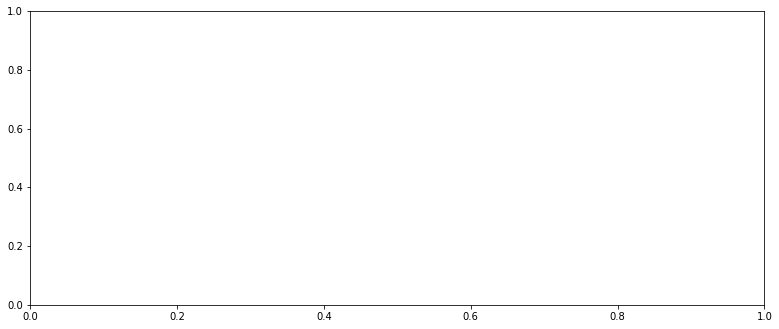

In [49]:
root_dir =  f"/NAS6/Members/linchenxi/projects/morocco/irrigation_regional_analysis"
samples = pd.DataFrame(data=[])
for year in range(2012, 2023):
    combined_ratio = pd.DataFrame(data=[])
    try:
        prec = pd.read_csv(os.path.join(root_dir, "prec", f"all_prec_{year}.csv"))[[f"prec_{i}" for i in range(1, 13)]+["FIELD_ID"]]
    except:
        prec = pd.DataFrame(data=[], columns=[f"prec_{i}" for i in range(1, 13)]+["FIELD_ID"])
    prec.fillna(method="ffill", inplace=True)
    prec.sort_values(by=["FIELD_ID"], inplace=True)
    for vi in ["NDVI", "EVI", "CIG", "LSWI", "OSAVI"]:
        try:
            if year == 2012 and vi == "NDVI":
                irri = pd.read_csv(os.path.join(root_dir, f"{vi}", f"all_{vi}_irri_{year}.csv"))[[f"{vi}_{i}" for i in range(1, 13)]+["FIELD_ID"]]
            else:
                irri = pd.read_csv(os.path.join(root_dir, f"{vi}", f"all_{vi}_irri_{year}.csv"))[[f"{vi}_{i}" for i in range(1, 13)]+["FIELD_ID"]]
        except:
            irri = pd.DataFrame(data=[], columns=[f"{vi}_{i}" for i in range(1, 13)+["FIELD_ID"]])
        irri.fillna(method="ffill", inplace=True)
        try:
            if year == 2012 and vi == "NDVI":
                rf = pd.read_csv(os.path.join(root_dir, f"{vi}", f"all_{vi}_rf_{year}.csv"))[[f"{vi}_{i}" for i in range(1, 13)]+["FIELD_ID"]]
            else:
                rf = pd.read_csv(os.path.join(root_dir, f"{vi}", f"all_{vi}_rf_{year}.csv"))[[f"{vi}_{i}" for i in range(1, 13)]+["FIELD_ID"]] 
        except:        
            rf = pd.DataFrame(data=[], columns=[f"{vi}_{i}" for i in range(1, 13)+["FIELD_ID"]])
        rf.fillna(method="ffill", inplace=True)
        if year == 2012 and vi == "NDVI":
            irri["class"] = 0
            rf["class"] = 1
        combined = pd.concat([irri, rf], axis=0).reset_index(drop=True)
        combined.sort_values(by=["FIELD_ID"])
        ratio = pd.DataFrame({f"{year}_{vi}_ratio": combined.max(axis=1) / prec.sum(axis=1)})
        if year == 2012 and vi == "NDVI":
            combined_ratio = pd.concat([combined_ratio, ratio, combined["class"], combined["FIELD_ID"]], axis=1)
        else:
            combined_ratio = pd.concat([combined_ratio, ratio], axis=1)
    samples = pd.concat([samples, combined_ratio], axis=1)
    selected_columns = samples.columns[samples.columns.str.contains(VI)]
    samples_viz = samples[selected_columns]
    irri_vi = samples[samples["class"]==0].drop(columns=["class", "FIELD_ID"]).to_numpy()
    rf_vi = samples[samples["class"]==1].drop(columns=["class", "FIELD_ID"]).to_numpy()
    make_fig(
        xdata=[range(0, len(irri_vi.mean(axis=0))), range(0, len(rf_vi.mean(axis=0)))],
        ydata=[irri_vi, rf_vi],
        legendlabel=["Irrigated Olives", "Rainfed Olives"],
        xlabel=f"{VI}",
        ylabel="Dates",
        ylim=viz_param[VI]["ylim"],
        yticks=viz_param[VI]["yticks"],
        xticks=[0, 3, 6, 9, 12],
        xticklabels=[2012, 2015, 2018, 2021, 2024])
    plt.savefig(fr"/NAS6/Members/linchenxi/projects/morocco/irrigation_regional_analysis/figures/{region}_{VI}_ratio.jpg")
    plt.cla()

In [42]:
samples_guercif = samples["FIELD_ID"].str.contains("GUERSIF") # provide samples for irrigation and rainfed
mask = samples_guercif
samples_filtered = samples[~mask]
train_rf = np.random.choice(samples_filtered[samples_filtered["class"] == 1].index, 30, replace=False)
train_irri = np.random.choice(samples_filtered[samples_filtered["class"] == 0].index, 30, replace=False)
test_rf = np.setdiff1d(samples_filtered[samples_filtered["class"] == 1].index, train_rf)
test_irri = np.setdiff1d(samples_filtered[samples_filtered["class"] == 0].index, train_irri)
# np.concatenate([index_rf, index_irri])
X_train = samples_filtered.loc[np.concatenate([train_rf, train_irri])].drop(columns=["class", "FIELD_ID"]).to_numpy()
y_train = samples_filtered.loc[np.concatenate([train_rf, train_irri])]["class"].to_numpy()
clf = RandomForestClassifier(max_depth=5, random_state=3, class_weight={0:0.66, 1:0.33})
clf.fit(X_train, y_train)
X_test = samples_filtered.loc[np.concatenate([test_rf, test_irri])].drop(columns=["class", "FIELD_ID"]).to_numpy()
y_test = samples_filtered.loc[np.concatenate([test_rf, test_irri])]["class"].to_numpy()
y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print (cm)
print ((y_pred == y_test).mean())

[[ 21   3]
 [  8 319]]
0.9686609686609686
